In [1]:
import numpy as np
from matplotlib import pyplot as plt

import jax.numpy as jnp
from jax import random, lax, jit, vmap

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.nested_sampling import NestedSampler

In [2]:
# Load data
lc = np.loadtxt("lc.txt")
interp = np.loadtxt("interp.txt")
t, F, Ferr = lc
points, zeta_e, zeta_n, zeta_e_dot, zeta_n_dot = interp

In [3]:
def model(t, F, Ferr):
    DeltaF = numpyro.sample("DeltaF", dist.LogNormal(4.0, 4.0))
    Fbase = numpyro.sample("Fbase", dist.LogNormal(2.0, 4.0))
    t0 = numpyro.sample("t0", dist.Normal(3630.0, 50.0))
    tE = numpyro.sample("tE", dist.LogNormal(3.0, 6.0))
    u0 = numpyro.sample("u0", dist.Normal(0.0, 1.0))
    piEE = numpyro.sample("piEE", dist.Normal(0.0, 0.5))
    piEN = numpyro.sample("piEN", dist.Normal(0.0, 0.5))

    # Compute trajectory
    zeta_e_t = jnp.interp(t, points, zeta_e)
    zeta_n_t = jnp.interp(t, points, zeta_n)
    zeta_e_t0 = jnp.interp(t0, points, zeta_e)
    zeta_n_t0 = jnp.interp(t0, points, zeta_n)
    zeta_e_dot_t0 = jnp.interp(t0, points, zeta_e_dot)
    zeta_n_dot_t0 = jnp.interp(t0, points, zeta_n_dot)

    delta_zeta_e = zeta_e_t - zeta_e_t0 - (t - t0) * zeta_e_dot_t0
    delta_zeta_n = zeta_n_t - zeta_n_t0 - (t - t0) * zeta_n_dot_t0

    u_per = u0 + piEN * delta_zeta_e - piEE * delta_zeta_n
    u_par = (t - t0) / tE + piEE * delta_zeta_e + piEN * delta_zeta_n
    u = jnp.sqrt(u_per ** 2 + u_par ** 2)

    # Magnification
    A_u = (u ** 2 + 2) / (u * jnp.sqrt(u ** 2 + 4))
    A_u0 = (u0 ** 2 + 2) / (jnp.abs(u0) * jnp.sqrt(u0 ** 2 + 4))
    A = (A_u - 1) / (A_u0 - 1)
    F_pred = DeltaF * A + Fbase

    ln_c = numpyro.sample("ln_c", dist.Exponential(1 / 2.0))
    numpyro.sample("data_dist", dist.Normal(F_pred, jnp.exp(ln_c) * Ferr), obs=F)

## Nested Sampling

In [4]:
ns = NestedSampler(model, num_live_points=1000)
rng_key = random.PRNGKey(0)
ns.run(rng_key, t, F, Ferr)

Number of weighted samples: 65854
Effective sample size: 11946.7


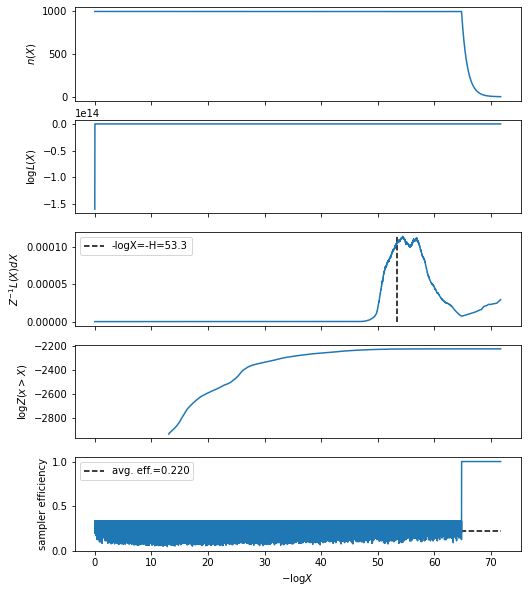

In [5]:
ns.diagnostics(cornerplot=False)  # cornerplot is slow

Resampling 100000 samples

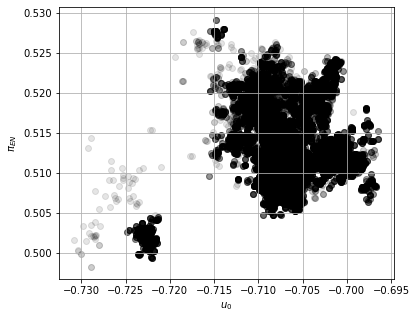

In [6]:
samples = ns.get_samples(random.PRNGKey(1), 100000)
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(samples["u0"], samples["piEN"], color="black", alpha=0.1)
# ax.set(xlim=(-0.8, 0.8), ylim=(-0.8, 0.8))
ax.set(xlabel=r"$u_0$", ylabel=r"$\pi_{EN}$")
ax.grid()

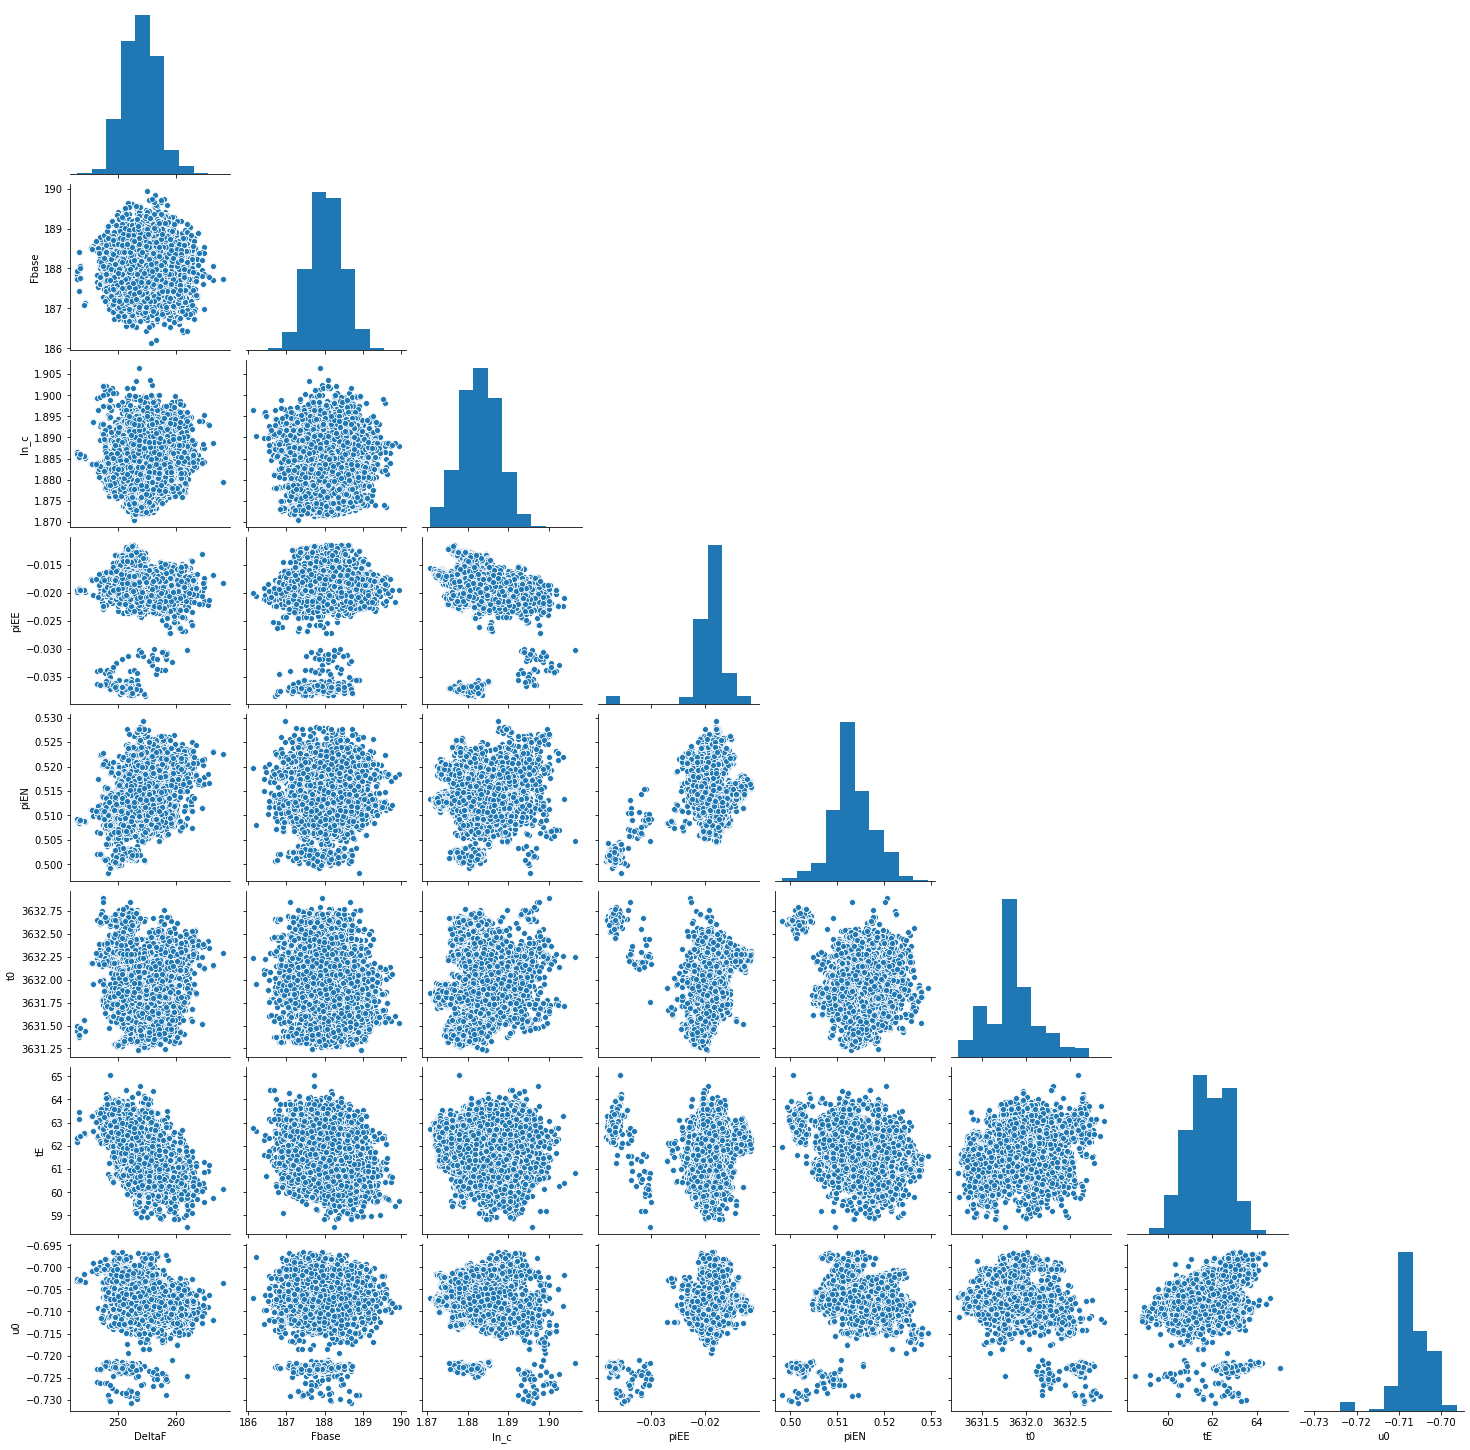

In [7]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame.from_dict(samples).astype(float)
sns.pairplot(df, corner=True);

No resampling

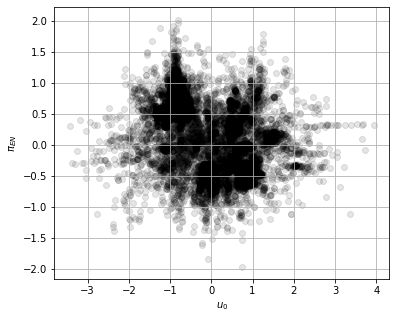

In [8]:
samples = ns._samples
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(samples["u0"], samples["piEN"], color="black", alpha=0.1)
# ax.set(xlim=(-0.8, 0.8), ylim=(-0.8, 0.8))
ax.set(xlabel=r"$u_0$", ylabel=r"$\pi_{EN}$")
ax.grid()

Restrict to (-0.8, 0.8) domains

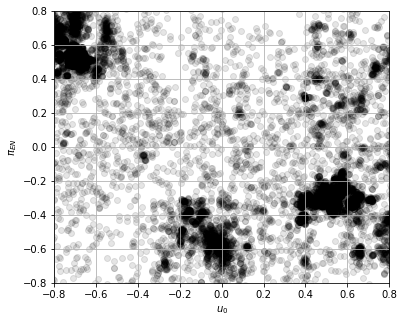

In [9]:
samples = ns._samples
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(samples["u0"], samples["piEN"], color="black", alpha=0.1)
ax.set(xlim=(-0.8, 0.8), ylim=(-0.8, 0.8))
ax.set(xlabel=r"$u_0$", ylabel=r"$\pi_{EN}$")
ax.grid()